<a id='top'></a>

## Jupyter notebook used in the paper:  
## Aeolian dune modelling from airborne LiDAR, terrestrial LiDAR and Structure from Motion--Multi View Stereo    
by Carlos H. Grohmann et al - 2019/2020  
guano (at) usp (dot) br  
[Institute of Energy and Environment](http://www.iee.usp.br/) - [University of Sao Paulo](https://www5.usp.br/#english) (IEE-USP)  
Spatial Analysis and Modelling Lab - [SPAMLab](https://spamlab.github.io/)

Please check the GitHub repo for the final reference to the paper ([here](https://github.com/CarlosGrohmann/scripts_papers/tree/master/garopaba_als_sfm_tls))  


This notebok has the test of the effect of noise reduction (despeckle) on SfM-MVS using Lindsay et al (2019) feature-preserving DEM smoothing (FPDEMS) algorithm (http://dx.doi.org/10.3390/rs11161926)  

The FPDEMS algorithm is provided with WhiteBoxTools (https://jblindsay.github.io/ghrg/WhiteboxTools/index.html)




### Imports and auxiliar functions.

In [1]:
# import python libraries
import sys, os, itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import rasterio as rio
import xarray as xr
import subprocess
from IPython.display import Image # can use this to display GRASS maps

In [2]:
# error measurements
def err_mse(x1, x2, axis=0):
    """mean squared error"""
    x1 = np.asanyarray(x1)
    x2 = np.asanyarray(x2)
    return np.mean((x1-x2)**2, axis=axis)

def err_rmse(x1, x2, axis=0):
    """root mean squared error"""
    x1 = np.asanyarray(x1)
    x2 = np.asanyarray(x2)
    return np.sqrt(err_mse(x1, x2, axis=axis))

def err_mae(x1, x2, axis=0):
    """mean absolute error"""
    x1 = np.asanyarray(x1)
    x2 = np.asanyarray(x2)
    return np.mean(np.abs(x1-x2), axis=axis)

In [3]:
# matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline

### GRASS setup

In [4]:
# requires version 7.8+
# create GRASS GIS runtime environment (mac and linux)
gisbase = subprocess.check_output(["grass79", "--config", "path"]).strip().decode()

os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# GRASS GIS imports
import grass.script as grass
import grass.script.setup as gsetup
import grass.script.array as garray
import grass.script.vector as gvect

# check GRASS version
# print(gisbase)

In [5]:
# set GRASS GIS session data
if sys.platform == "linux" or sys.platform == "linux2":
    rcfile = gsetup.init(gisbase, "/mnt/sda/grassdata/", "utm", "garopaba_22J")
elif sys.platform == "darwin":
    rcfile = gsetup.init(gisbase, "/Volumes/MacintoshHD2/grassdata/", "utm", "garopaba_22J")
    
# grass.message('Current GRASS GIS 7 environment:')
print (grass.gisenv())

{'GISDBASE': '/Volumes/MacintoshHD2/grassdata/', 'LOCATION_NAME': 'utm', 'MAPSET': 'garopaba_22J'}


In [6]:
# overwrite for GRASS modules
ow = True

### Data directory

In [7]:
# Data dir 
if sys.platform == "linux" or sys.platform == "linux2":
    dataDir = '/mnt/sda/Dropbox/USP/projetosPesquisa/LiDAR_terrestre_SfM/_areas_estudo/garopaba/DEMs_shapes'
elif sys.platform == "darwin":
    dataDir = '/Volumes/MacintoshHD2/Dropbox/USP/projetosPesquisa/LiDAR_terrestre_SfM/_areas_estudo/garopaba/DEMs_shapes'

### Variables names

In [8]:
mask_tls = 'mask_tls'
mask_sfm = 'mask_sfm' # mask for clipping (pretty much the whole SfM area)
mask_tls_sfm = 'mask_tls_sfm'

In [9]:
# Names and files
sfm_avg10cm = 'sfm_rinxyz_avg10cm'
tls_avg10cm = 'tls_rinxyz_avg10cm'

In [10]:
# settings for interpolation, shaded reliefs, names for the files
method='bilinear'
step = 0.5
altitude = 30
azimuth = 25
az_txt = f'{azimuth:>03.0f}' #'{:>03.0f}'.format(azimuth)

dem_tls_10cm = f'tls_rinxyz_avg10cm_{method}_step_{str(step)}'
dem_tls_10cm_shade = f'{dem_tls_10cm}_shade_{az_txt}_{str(altitude)}'

dem_sfm_10cm = f'sfm_rinxyz_avg10cm_{method}_step_{str(step)}'
dem_sfm_10cm_shade = f'{dem_sfm_10cm}_shade_{az_txt}_{str(altitude)}'

diff_sfm_tls_10cm = 'diff_10cm_sfm_tls'
diff_sfm_tls_10cm_shade = f'{diff_sfm_tls_10cm}_shade_{az_txt}_{str(altitude)}'

In [11]:
# # set region and mask
# mask_tls = 'mask_tls'
# grass.run_command('g.region', vector=mask_tls, res=0.1, flags='pa')
# grass.run_command('r.mask', vector=mask_tls, overwrite=ow)

In [12]:
# settings for roughness, names for the files
w = 5  # window size
op = 'stddev' # neighborhood operation

tls_slope = dem_tls_10cm + '_slope'
sfm_slope = dem_sfm_10cm + '_slope'

tls_rough = tls_slope + '_std_' + str(w) + 'x' + str(w)
sfm_rough = sfm_slope + '_std_' + str(w) + 'x' + str(w)

### Noise reduction

In [13]:
# import WhiteBoxTools (requires tkinter)
import whitebox
wbt = whitebox.WhiteboxTools()
# print(wbt.version())
# print(wbt.help())
wbt.verbose = False

In [14]:
# GRASS - set sub-region for testing
dnoise_dir = f'{dataDir}/denoise'
sfm_export = f'{dnoise_dir}/{dem_sfm_10cm}.tif'
tls_export = f'{dnoise_dir}/{dem_tls_10cm}.tif'
denoise_area = 'denoise_area'
grass.run_command('g.region', n=6900100, s=6900030, w=732360, e=732430, res=0.1, flags='pa');
grass.run_command('v.in.region', output=denoise_area, overwrite=ow)

In [186]:
# export DEM as tiff
grass.run_command('r.out.gdal', input=dem_sfm_10cm, output=sfm_export, format='GTiff', overwrite=ow)
grass.run_command('r.out.gdal', input=dem_tls_10cm, output=tls_export, format='GTiff', overwrite=ow)

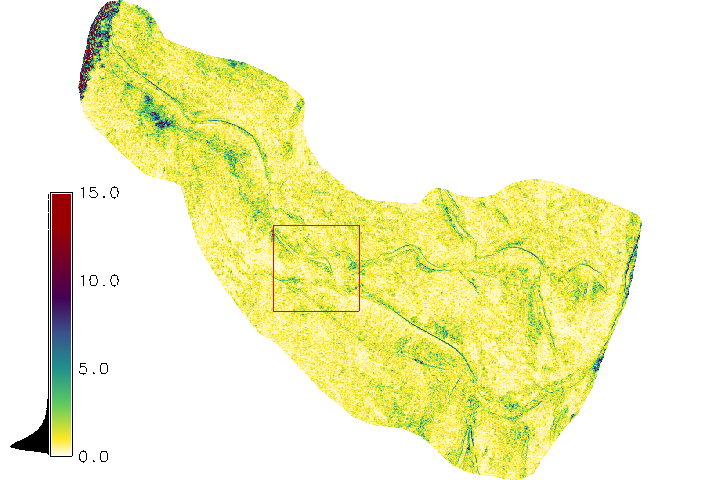

In [126]:
# display with virtual monitor rendered to png
grass.run_command('g.region', vector=mask_tls, res=0.1, flags='pa')
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=sfm_rough)
grass.run_command('d.legend', raster=sfm_rough, at='5,60,7,10', range='0,15', flags='sd', label_step=5)
grass.run_command('d.vect', map=denoise_area, fill_color='none', color='red') # mask for fpdems testing
Image('view.png') 

In [127]:
grass.run_command('d.mon', stop='png') 

## Run FPDEMS with different parameters 

### Test Threshold Value, fix k and i

In [54]:
thres = [5,10,15,20,25,30,35,40,45] # angular threshold
cva_krnl = [3,5,7,9,11,13,15,17,19,21,31,41] # CVA kernels
tck = [(t,ck) for t in thres for ck in cva_krnl]
k = 15
i = 5

In [136]:
# compute FPD for SfM DEMS
for t in  thres:
    fpd = f'{dnoise_dir}/threshold/{dem_sfm_10cm}_fpd_i{i}_t{t}_k{k}.tif'
    wbt.feature_preserving_smoothing(
        dem = sfm_export, 
        output = fpd, 
        filter = k, 
        norm_diff = t, 
        num_iter = i,
    );

In [137]:
# compute CVA for FPD DEMS
for t,ck in  tck:
    fpd = f'{dnoise_dir}/threshold/{dem_sfm_10cm}_fpd_i{i}_t{t}_k{k}.tif'
    cva_tif = f'{dnoise_dir}/threshold/{dem_sfm_10cm}_fpd_i{i}_t{t}_k{k}_cva{ck}.tif'
    wbt.circular_variance_of_aspect(
        dem = fpd, 
        output = cva_tif, 
        filter = ck, 
    );

In [138]:
# compute CVA for original SfM DEM
for ck in cva_krnl:
    cva_tif = f'{dnoise_dir}/threshold/{dem_sfm_10cm}_cva{ck}.tif'
    wbt.circular_variance_of_aspect(
        dem = sfm_export, 
        output = cva_tif, 
        filter = ck, 
    );

In [42]:
# read into dataframe
fpd_cva = pd.DataFrame()

# CVA for original SfM
for ck in cva_krnl:
    cva_tif = f'{dnoise_dir}/threshold/{dem_sfm_10cm}_cva{ck}.tif'
    tif = xr.open_rasterio(cva_tif)
    fpd_cva[f'sfm_cva{ck}'] = tif.to_series().dropna()

# CVA for FPD
for t,ck in  tck:
    cva_tif = f'{dnoise_dir}/threshold/{dem_sfm_10cm}_fpd_i{i}_t{t}_k{k}_cva{ck}.tif'
    tif = xr.open_rasterio(cva_tif)
    fpd_cva[f't{t}_cva{ck}'] = tif.to_series().dropna()

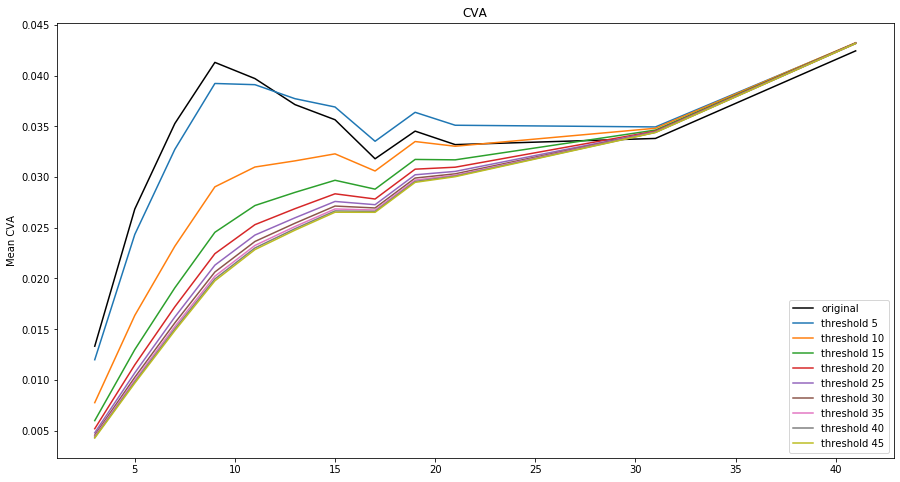

In [43]:
# plot mean CVA for each threshold
plt.figure(figsize=(15,8))
plt.title('CVA')
plt.ylabel('Mean CVA')

# original data
x = []
y = []
for ck in cva_krnl:
    col = f'sfm_cva{ck}'
    cva = fpd_cva[col].mean()
    x.append(ck)
    y.append(cva)
plt.plot(x,y,'-',label=f'original',c='black')

for t in  thres:
    x = []
    y = []
    for ck in cva_krnl:
        col = f't{t}_cva{ck}'
        cva = fpd_cva[col].mean()
        x.append(ck)
        y.append(cva)
    plt.plot(x,y,'-',label=f'threshold {t}')
    
# legend
plt.legend()
plt.savefig(f'{dnoise_dir}/plot_fpdems_cva_threshold.svg')

In [29]:
# read into dataframe - for RMSE
fpd_tls_t = pd.DataFrame()

# TLS
tls_tif = f'{dnoise_dir}/{dem_tls_10cm}.tif'
tif = xr.open_rasterio(tls_tif)
fpd_tls_t['tls'] = tif.to_series().dropna()

# original SfM
sfm_tif = f'{dnoise_dir}/{dem_sfm_10cm}.tif'
tif = xr.open_rasterio(sfm_tif)
fpd_tls_t['sfm'] = tif.to_series().dropna()

# SfM FPD 
for t in  thres:
    fpd_tif = f'{dnoise_dir}/threshold/{dem_sfm_10cm}_fpd_i{i}_t{t}_k{k}.tif'
    tif = xr.open_rasterio(fpd_tif)
    fpd_tls_t[f'fpd_t{t}'] = tif.to_series().dropna()

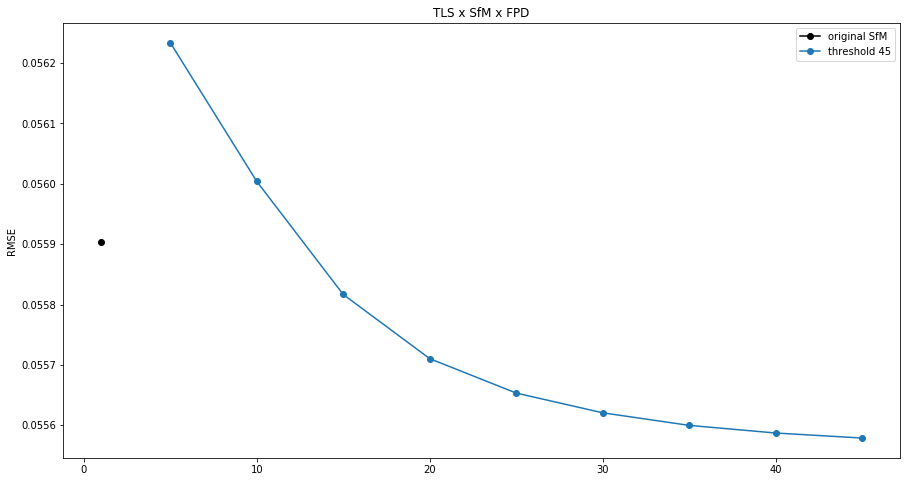

In [65]:
# plot RMSE for each threshold
plt.figure(figsize=(15,8))
plt.title('TLS x SfM x FPD')
plt.ylabel('RMSE')


# original SfM x TLS
x0 = 1
y0 = err_rmse(fpd_tls_t['sfm'],fpd_tls_t['tls'])
plt.plot(x0,y0,'-o',label=f'original SfM',c='black')

# FPD
x_t = []
y_t = []
for t in  thres:
    col = f'fpd_t{t}'
    rmse = err_rmse(fpd_tls_t[col],fpd_tls_t['tls'])
    x_t.append(t)
    y_t.append(rmse)
plt.plot(x_t,y_t,'-o',label=f'threshold {t}')
    
# legend
plt.legend()
plt.savefig(f'{dnoise_dir}/plot_fpdems_RMSE_threshold.svg')

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### test number of iterations, fix k and t

In [56]:
iters = [3,5,7,9,15,20,25,30] # iterations
cva_krnl = [3,5,7,9,11,13,15,17,19,21,31,41] # CVA kernels
ick = [(i,ck) for i in iters for ck in cva_krnl]
k = 15
t = 20

In [39]:
# compute FPD for SfM DEMS
for i in  iters:
    fpd = f'{dnoise_dir}/iterations/{dem_sfm_10cm}_fpd_i{i}_t{t}_k{k}.tif'
    wbt.feature_preserving_smoothing(
        dem = sfm_export, 
        output = fpd, 
        filter = k, 
        norm_diff = t, 
        num_iter = i,
    );

In [189]:
# compute CVA for FPD DEMS
for i,ck in  ick:
    fpd = f'{dnoise_dir}/iterations/{dem_sfm_10cm}_fpd_i{i}_t{t}_k{k}.tif'
    cva_tif = f'{dnoise_dir}/iterations/{dem_sfm_10cm}_fpd_i{i}_t{t}_k{k}_cva{ck}.tif'
    wbt.circular_variance_of_aspect(
        dem = fpd, 
        output = cva_tif, 
        filter = ck, 
    );

In [190]:
# compute CVA for original SfM DEM
for ck in cva_krnl:
    cva_tif = f'{dnoise_dir}/iterations/{dem_sfm_10cm}_cva{ck}.tif'
    wbt.circular_variance_of_aspect(
        dem = sfm_export, 
        output = cva_tif, 
        filter = ck, 
    );

In [45]:
# read into dataframe
fpd_cva = pd.DataFrame()

# CVA for original SfM
for ck in cva_krnl:
    cva_tif = f'{dnoise_dir}/iterations/{dem_sfm_10cm}_cva{ck}.tif'
    tif = xr.open_rasterio(cva_tif)
    fpd_cva[f'sfm_cva{ck}'] = tif.to_series().dropna()    
    
# CVA for FPD 
for i,ck in  ick:
    cva_tif = f'{dnoise_dir}/iterations/{dem_sfm_10cm}_fpd_i{i}_t{t}_k{k}_cva{ck}.tif'
    tif = xr.open_rasterio(cva_tif)
    fpd_cva[f'i{i}_cva{ck}'] = tif.to_series().dropna()

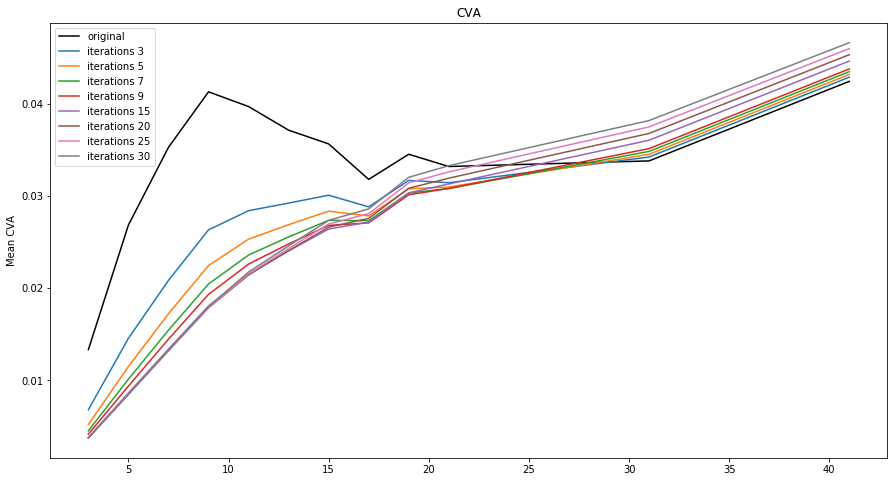

In [46]:
# plot mean CVA for each iteration 
plt.figure(figsize=(15,8))
plt.title('CVA')
plt.ylabel('Mean CVA')

# original data
x = []
y = []
for ck in cva_krnl:
    col = f'sfm_cva{ck}'
    cva = fpd_cva[col].mean()
    x.append(ck)
    y.append(cva)
plt.plot(x,y,'-',label=f'original',c='black')

for i in  iters:
    x = []
    y = []
    for ck in cva_krnl:
        col = f'i{i}_cva{ck}'
        cva = fpd_cva[col].mean()
        x.append(ck)
        y.append(cva)
    plt.plot(x,y,'-',label=f'iterations {i}')
    
# legend
plt.legend()
plt.savefig(f'{dnoise_dir}/plot_fpdems_cva_iterations.svg')

In [40]:
# read into dataframe - for RMSE
fpd_tls_i = pd.DataFrame()

# TLS
tls_tif = f'{dnoise_dir}/{dem_tls_10cm}.tif'
tif = xr.open_rasterio(tls_tif)
fpd_tls_i['tls'] = tif.to_series().dropna()

# original SfM
sfm_tif = f'{dnoise_dir}/{dem_sfm_10cm}.tif'
tif = xr.open_rasterio(sfm_tif)
fpd_tls_i['sfm'] = tif.to_series().dropna()

# SfM FPD 
for i in  iters:
    fpd_tif = f'{dnoise_dir}/iterations/{dem_sfm_10cm}_fpd_i{i}_t{t}_k{k}.tif'
    tif = xr.open_rasterio(fpd_tif)
    fpd_tls_i[f'fpd_i{i}'] = tif.to_series().dropna()

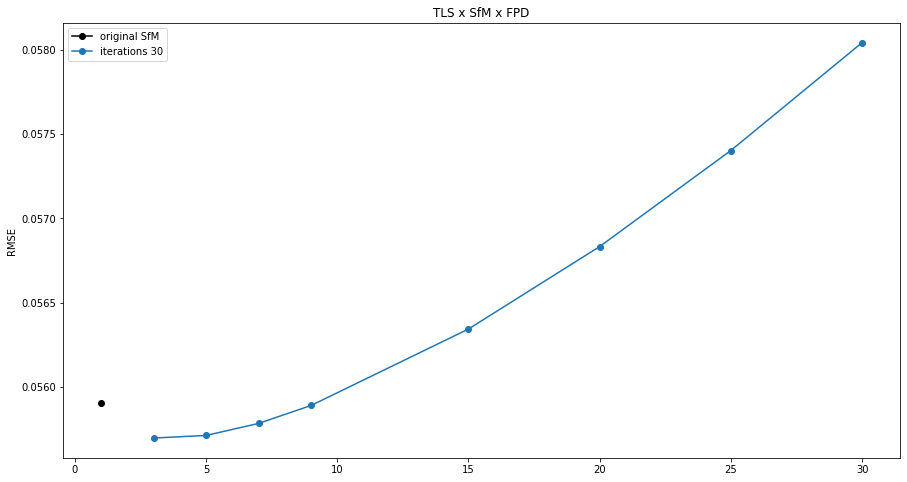

In [57]:
# plot RMSE for each iteration
plt.figure(figsize=(15,8))
plt.title('TLS x SfM x FPD')
plt.ylabel('RMSE')


# original SfM x TLS
x0 = 1
y0 = err_rmse(fpd_tls_i['sfm'],fpd_tls_i['tls'])
plt.plot(x0,y0,'-o',label=f'original SfM',c='black')

# FPD
x_i = []
y_i = []
for i in  iters:
    col = f'fpd_i{i}'
    rmse = err_rmse(fpd_tls_i[col],fpd_tls_i['tls'])
    x_i.append(i)
    y_i.append(rmse)
plt.plot(x_i,y_i,'-o',label=f'iterations {i}')
    
# legend
plt.legend()
plt.savefig(f'{dnoise_dir}/plot_fpdems_RMSE_iterations.svg')

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### test kernel size, fix t and i

In [58]:
fpd_krnl = [5,7,9,11,13,15,17,19,21,31,41,51] # FPD kernels 
cva_krnl = [3,5,7,9,11,13,15,17,19,21,31,41] # CVA kernels
kck = [(k,ck) for k in fpd_krnl for ck in cva_krnl]
i = 5
t = 20

In [194]:
# compute FPD for SfM DEMS
for k in  fpd_krnl:
    fpd = f'{dnoise_dir}/fpd_kernel/{dem_sfm_10cm}_fpd_i{i}_t{t}_k{k}.tif'
    wbt.feature_preserving_smoothing(
        dem = sfm_export, 
        output = fpd, 
        filter = k, 
        norm_diff = t, 
        num_iter = i,
    );

In [195]:
# compute CVA for FPD DEMS
for k,ck in  kck:
    fpd = f'{dnoise_dir}/fpd_kernel/{dem_sfm_10cm}_fpd_i{i}_t{t}_k{k}.tif'
    cva_tif = f'{dnoise_dir}/fpd_kernel/{dem_sfm_10cm}_fpd_i{i}_t{t}_k{k}_cva{ck}.tif'
    wbt.circular_variance_of_aspect(
        dem = fpd, 
        output = cva_tif, 
        filter = ck, 
    );

In [196]:
# compute CVA for original SfM DEM
for ck in cva_krnl:
    cva_tif = f'{dnoise_dir}/fpd_kernel/{dem_sfm_10cm}_cva{ck}.tif'
    wbt.circular_variance_of_aspect(
        dem = sfm_export, 
        output = cva_tif, 
        filter = ck, 
    );

In [63]:
# read into dataframe
fpd_cva = pd.DataFrame()

# CVA for original SfM
for ck in cva_krnl:
    cva_tif = f'{dnoise_dir}/fpd_kernel/{dem_sfm_10cm}_cva{ck}.tif'
    tif = xr.open_rasterio(cva_tif)
    fpd_cva[f'sfm_cva{ck}'] = tif.to_series().dropna() 
    
# CVA for FPD 
for k,ck in  kck:
    cva_tif = f'{dnoise_dir}/fpd_kernel/{dem_sfm_10cm}_fpd_i{i}_t{t}_k{k}_cva{ck}.tif'
    tif = xr.open_rasterio(cva_tif)
    fpd_cva[f'k{k}_cva{ck}'] = tif.to_series().dropna() 

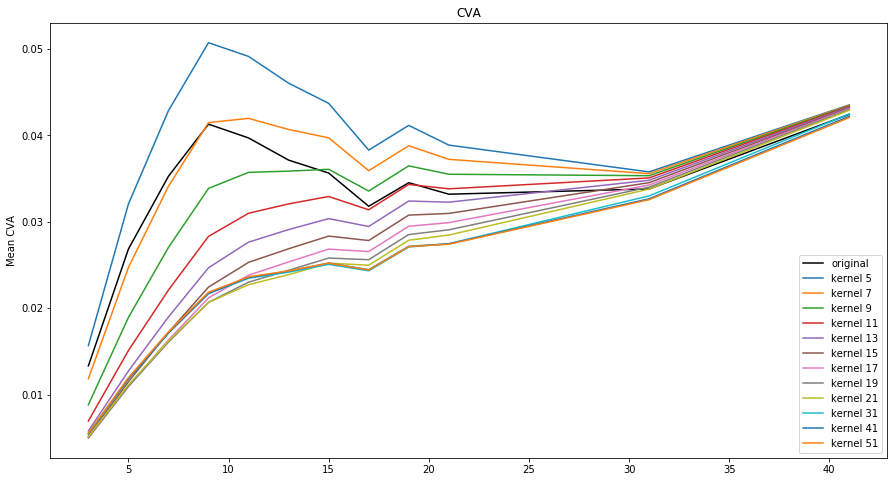

In [64]:
# plot mean CVA for each kernel
plt.figure(figsize=(15,8))
plt.title('CVA')
plt.ylabel('Mean CVA')

# original data
x = []
y = []
for ck in cva_krnl:
    col = f'sfm_cva{ck}'
    cva = fpd_cva[col].mean()
    x.append(ck)
    y.append(cva)
plt.plot(x,y,'-',label=f'original',c='black')

for k in  fpd_krnl:
    x = []
    y = []
    for ck in cva_krnl:
        col = f'k{k}_cva{ck}'
        cva = fpd_cva[col].mean()
        x.append(ck)
        y.append(cva)
    plt.plot(x,y,'-',label=f'kernel {k}')
    
# legend
plt.legend()
plt.savefig(f'{dnoise_dir}/plot_fpdems_cva_kernels.svg')

In [50]:
# read into dataframe - for RMSE
fpd_tls_k = pd.DataFrame()

# TLS
tls_tif = f'{dnoise_dir}/{dem_tls_10cm}.tif'
tif = xr.open_rasterio(tls_tif)
fpd_tls_k['tls'] = tif.to_series().dropna()

# original SfM
sfm_tif = f'{dnoise_dir}/{dem_sfm_10cm}.tif'
tif = xr.open_rasterio(sfm_tif)
fpd_tls_k['sfm'] = tif.to_series().dropna()

# SfM FPD 
for k in  fpd_krnl:
    fpd_tif = f'{dnoise_dir}/fpd_kernel/{dem_sfm_10cm}_fpd_i{i}_t{t}_k{k}.tif'
    tif = xr.open_rasterio(fpd_tif)
    fpd_tls_k[f'fpd_k{k}'] = tif.to_series().dropna()

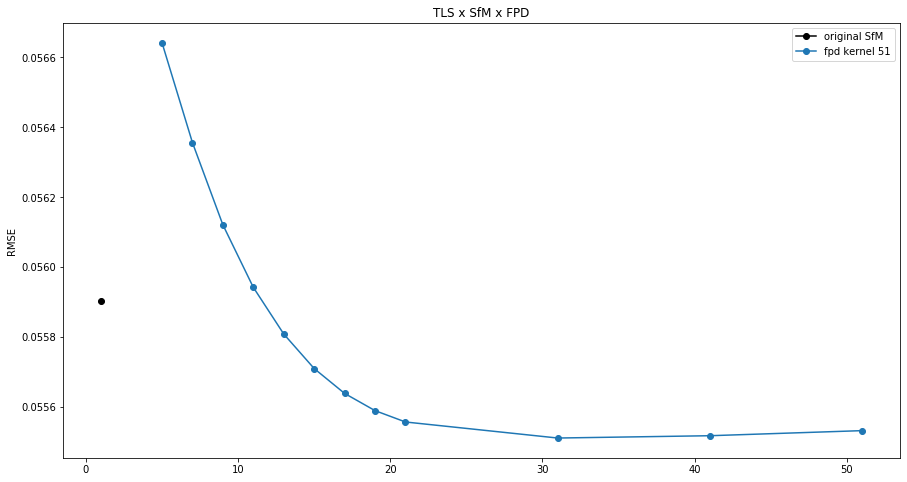

In [67]:
# plot RMSE for each kernel
plt.figure(figsize=(15,8))
plt.title('TLS x SfM x FPD')
plt.ylabel('RMSE')


# original SfM x TLS
x0 = 1
y0 = err_rmse(fpd_tls_k['sfm'],fpd_tls_k['tls'])
plt.plot(x0,y0,'-o',label=f'original SfM',c='black')

# FPD
x_k = []
y_k = []
for k in  fpd_krnl:
    col = f'fpd_k{k}'
    rmse = err_rmse(fpd_tls_k[col],fpd_tls_k['tls'])
    x_k.append(k)
    y_k.append(rmse)
plt.plot(x_k,y_k,'-o',label=f'fpd kernel {k}')
    
# legend
plt.legend()
plt.savefig(f'{dnoise_dir}/plot_fpdems_RMSE_fpd-kernel.svg')

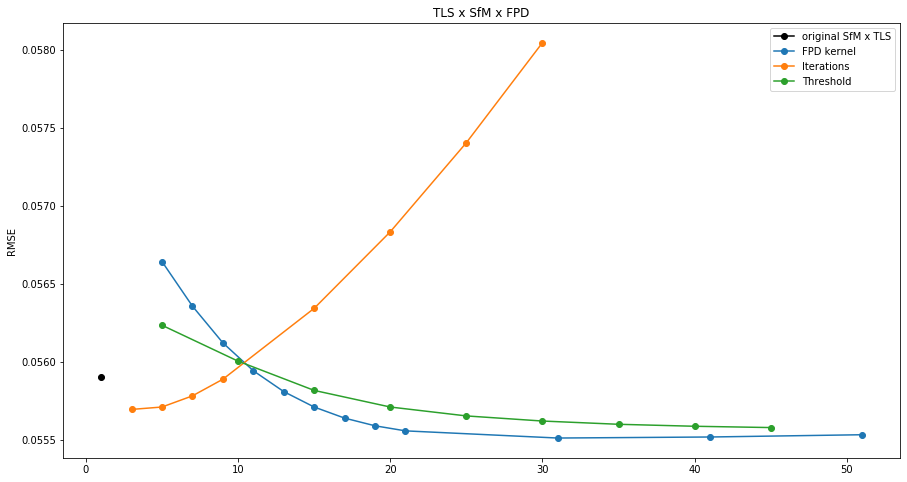

In [70]:
# all in one
plt.figure(figsize=(15,8))
plt.title('TLS x SfM x FPD')
plt.ylabel('RMSE')

plt.plot(x0,y0,'-o',label=f'original SfM x TLS',c='black')
plt.plot(x_k,y_k,'-o',label=f'FPD kernel')
plt.plot(x_i,y_i,'-o',label=f'Iterations')
plt.plot(x_t,y_t,'-o',label=f'Threshold')
plt.legend()

plt.savefig(f'{dnoise_dir}/plot_fpdems_RMSE_all.svg')

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

#### Run FPD for entire SfM DEM

In [199]:
# GRASS - set region, mask, export full DEM as tiff
mask_tls = 'mask_tls'
grass.run_command('g.region', vector=mask_tls, res=0.1, flags='pa')
grass.run_command('r.mask', vector=mask_tls, overwrite=ow)
dnoise_dir = f'{dataDir}/denoise'
sfm_export_full = f'{dnoise_dir}/{dem_sfm_10cm}_full.tif'
grass.run_command('r.out.gdal', input=dem_sfm_10cm, output=sfm_export_full, format='GTiff', overwrite=ow)

In [200]:
# settings for FPD
k = 17
i = 5
t = 20

In [201]:
# compute FPD 
fpd = f'{dnoise_dir}/{dem_sfm_10cm}_full_fpd_i{i}_t{t}_k{k}.tif'
wbt.feature_preserving_smoothing(
    dem = sfm_export_full, 
    output = fpd, 
    filter = k, 
    norm_diff = t, 
    num_iter = i,
);

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

#### Import back into GRASS and calculate surface roughness

In [202]:
# set region and mask
mask_tls = 'mask_tls'
grass.run_command('g.region', vector=mask_tls, res=0.1, flags='pa')
grass.run_command('r.mask', vector=mask_tls, overwrite=ow)

In [208]:
fpd = f'{dnoise_dir}/{dem_sfm_10cm}_full_fpd_i{i}_t{t}_k{k}.tif'
sfm_fpd = f'{dem_sfm_10cm}_full_fpd_i{i}_t{t}_k{k}' 
grass.run_command('r.in.gdal', input=fpd, output=sfm_fpd, flags='o', overwrite=ow)

In [209]:
# settings for roughness, names for the files
w = 5  # window size
op = 'stddev' # neighborhood operation

sfm_fpd_slope = f'{grs_fpd}_slope'
sfm_fpd_rough = f'{sfm_fpd_slope}_std_{w}x{w}'

In [210]:
# slope
grass.run_command('r.slope.aspect', elevation=sfm_fpd, slope=sfm_fpd_slope, overwrite=ow)

In [211]:
# roughness
grass.run_command('r.neighbors', input=sfm_fpd_slope, output=sfm_fpd_rough, method=op, size=w, overwrite=ow)

In [212]:
# set custom colortable, based on viridis
rules='''0 255:255:255
1 253:231:37
3 93:201:98
5 32:144:141
7 58:82:139
9 68:1:84
13 155:0:0
30 155:0:0
'''
# save rules to file
with open('rules.txt', 'w+') as file:
    file.write(rules)

grass.run_command('r.colors', map=sfm_fpd_rough, rules='rules.txt')

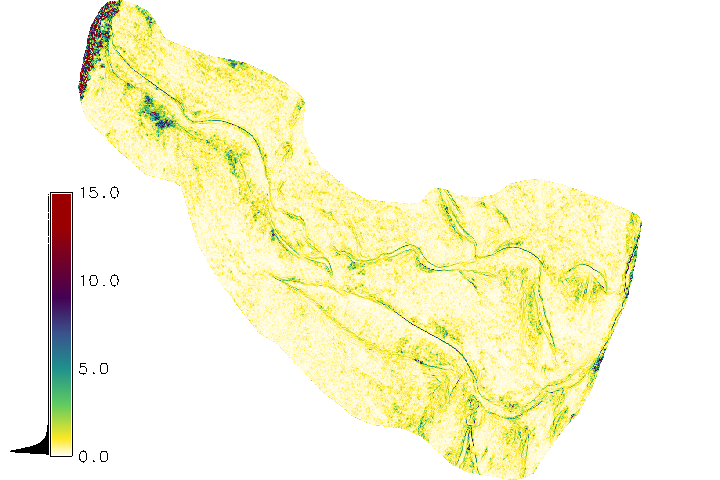

In [213]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=sfm_fpd_rough)
grass.run_command('d.legend', raster=sfm_fpd_rough, at='5,60,7,10', range='0,15', flags='sd', label_step=5)
Image('view.png') 

In [214]:
grass.run_command('d.mon', stop='png') 

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>